based on https://github.com/experiencor/keras-yolo3

# 설치

## tensorlfow 1.x 사용 설정

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## 프로젝트 다운로드

In [2]:
!rm -rf keras-yolo3
!git clone https://github.com/experiencor/keras-yolo3

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 220, done.
remote: Total 220 (delta 0), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (220/220), 91.27 KiB | 258.00 KiB/s, done.
Resolving deltas: 100% (118/118), done.


In [3]:
%cd keras-yolo3

/content/keras-yolo3


## 필요 라이브러리 설치

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 2.4MB 8.0MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 1.3MB 55.4MB/s 
     |████████████████████████████████| 276kB 58.9MB/s 
     |████████████████████████████████| 412.3MB 35kB/s 
     |████████████████████████████████| 327kB 36.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=35d13be303d267957898ad37b9decc3395c9aecd6b9698d6e62db67d77632a18
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp36-none-any.whl size=61682 sha256=7bd12cb0ee9dc4971b9530cb8d7322097bd9c745e2d7a19963bac70bb98aec81
  Stored in directory: /root/.cache/

## 모델 파일 다운로드

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-06-24 04:25:25--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   526KB/s    in 9m 28s  

2020-06-24 04:34:55 (426 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# 탐지

## 대상 이미지 다운로드

In [6]:
!wget -O dog.jpg https://images.squarespace-cdn.com/content/v1/5894986a3e00bef5fa22310e/1570645718385-TMKO7NQKTKMHSGOZ1NKL/ke17ZwdGBToddI8pDm48kP9Invdr3s9hbtnv5vHbyzt7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UTG8VVHpRe-xI0OO_s6cEC9VLEx2PmUh6Z7HRdaNSVcy1BwhnUnKb_77tZJ4rR3HLQ/golden+huggs.jpg?format=400w

--2020-06-24 04:36:58--  https://images.squarespace-cdn.com/content/v1/5894986a3e00bef5fa22310e/1570645718385-TMKO7NQKTKMHSGOZ1NKL/ke17ZwdGBToddI8pDm48kP9Invdr3s9hbtnv5vHbyzt7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UTG8VVHpRe-xI0OO_s6cEC9VLEx2PmUh6Z7HRdaNSVcy1BwhnUnKb_77tZJ4rR3HLQ/golden+huggs.jpg?format=400w
Resolving images.squarespace-cdn.com (images.squarespace-cdn.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to images.squarespace-cdn.com (images.squarespace-cdn.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57764 (56K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  56.41K  --.-KB/s    in 0.03s   

2020-06-24 04:36:58 (2.02 MB/s) - ‘dog.jpg’ saved [57764/57764]



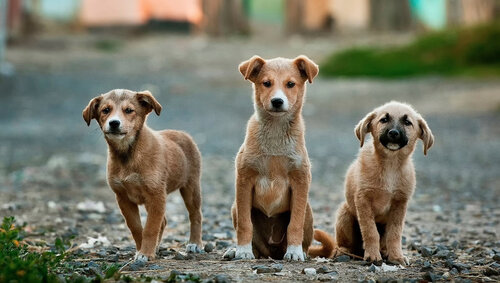

In [7]:
from IPython.display import Image, display
display(Image('dog.jpg'))

## 버그 픽스

from https://github.com/experiencor/keras-yolo3/issues/203

다음 라인을 커멘트 처리.
```
np.set_printoptions(threshold=np.nan)
```

In [8]:
!sed -i 's/np\.set_printoptions/\#np\.set_printoptions/g' yolo3_one_file_to_detect_them_all.py

In [9]:
!head -20 yolo3_one_file_to_detect_them_all.py

import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2

#np.set_printoptions(threshold=np.nan)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

argparser = argparse.ArgumentParser(
    description='test yolov3 network with coco weights')

argparser.add_argument(
    '-w',
    '--weights',
    help='path to weights file')


## 탐지 실행

In [10]:
!python yolo3_one_file_to_detect_them_all.py -w yolov3.weights -i dog.jpg

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-06-24 04:37:50.893534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-24 04:37:50.940411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-24 04:37:50.940957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2020-06-24 04:37:50.959427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-06-24 04:37:51.175951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-06-24 04:37:51.26506

# 학습 데이터 준비

## 학습 데이터셋 다운로드

In [11]:
!git clone https://github.com/experiencor/raccoon_dataset


Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [12]:
!ls -al raccoon_dataset/images | head
!ls -al raccoon_dataset/annotations | head

total 13448
drwxr-xr-x 2 root root  12288 Jun 24 04:40 .
drwxr-xr-x 7 root root   4096 Jun 24 04:40 ..
-rw-r--r-- 1 root root 118176 Jun 24 04:40 raccoon-100.jpg
-rw-r--r-- 1 root root 124554 Jun 24 04:40 raccoon-101.jpg
-rw-r--r-- 1 root root  17123 Jun 24 04:40 raccoon-102.jpg
-rw-r--r-- 1 root root 173619 Jun 24 04:40 raccoon-103.jpg
-rw-r--r-- 1 root root  41618 Jun 24 04:40 raccoon-104.jpg
-rw-r--r-- 1 root root  99844 Jun 24 04:40 raccoon-105.jpg
-rw-r--r-- 1 root root  13337 Jun 24 04:40 raccoon-106.jpg
total 816
drwxr-xr-x 2 root root 12288 Jun 24 04:40 .
drwxr-xr-x 7 root root  4096 Jun 24 04:40 ..
-rw-r--r-- 1 root root   559 Jun 24 04:40 raccoon-100.xml
-rw-r--r-- 1 root root   558 Jun 24 04:40 raccoon-101.xml
-rw-r--r-- 1 root root   556 Jun 24 04:40 raccoon-102.xml
-rw-r--r-- 1 root root   558 Jun 24 04:40 raccoon-103.xml
-rw-r--r-- 1 root root   559 Jun 24 04:40 raccoon-104.xml
-rw-r--r-- 1 root root   559 Jun 24 04:40 raccoon-105.xml
-rw-r--r-- 1 root root   558 Jun 24 0

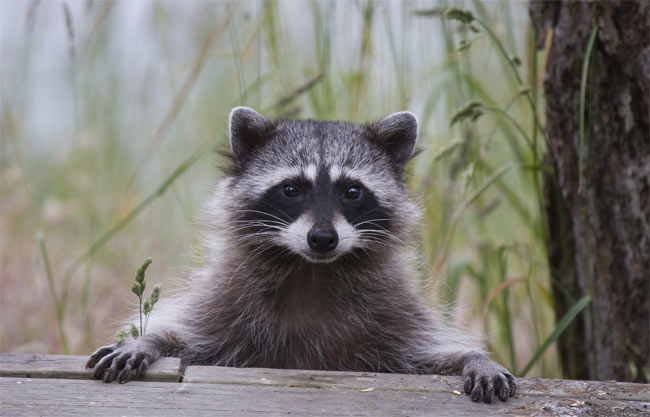

In [13]:
from IPython.display import Image, display
display(Image('raccoon_dataset/images/raccoon-1.jpg'))

In [14]:
!cat raccoon_dataset/annotations/raccoon-100.xml

<annotation verified="yes">
	<folder>images</folder>
	<filename>raccoon-100.jpg</filename>
	<path>/Users/datitran/Desktop/raccoon/images/raccoon-100.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>960</width>
		<height>576</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>raccoon</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>548</xmin>
			<ymin>10</ymin>
			<xmax>954</xmax>
			<ymax>520</ymax>
		</bndbox>
	</object>
</annotation>


## 디렉토리 생성

```
data/
  train/
    images/
    annotations/
  test/
    images/
    annotations/

```

In [15]:
!mkdir -p data/train/images
!mkdir -p data/train/annotations
!mkdir -p data/test/images
!mkdir -p data/test/annotations

전체 데이터를 전부 train/ 밑으로 복사하고

In [16]:
!cp raccoon_dataset/images/* data/train/images
!cp raccoon_dataset/annotations/* data/train/annotations

In [17]:
!ls -al data/train/images | head
!ls -al data/train/annotations | head
!ls data/train/images/*.jpg | wc

total 13448
drwxr-xr-x 2 root root  12288 Jun 24 04:43 .
drwxr-xr-x 4 root root   4096 Jun 24 04:43 ..
-rw-r--r-- 1 root root 118176 Jun 24 04:43 raccoon-100.jpg
-rw-r--r-- 1 root root 124554 Jun 24 04:43 raccoon-101.jpg
-rw-r--r-- 1 root root  17123 Jun 24 04:43 raccoon-102.jpg
-rw-r--r-- 1 root root 173619 Jun 24 04:43 raccoon-103.jpg
-rw-r--r-- 1 root root  41618 Jun 24 04:43 raccoon-104.jpg
-rw-r--r-- 1 root root  99844 Jun 24 04:43 raccoon-105.jpg
-rw-r--r-- 1 root root  13337 Jun 24 04:43 raccoon-106.jpg
total 816
drwxr-xr-x 2 root root 12288 Jun 24 04:43 .
drwxr-xr-x 4 root root  4096 Jun 24 04:43 ..
-rw-r--r-- 1 root root   559 Jun 24 04:43 raccoon-100.xml
-rw-r--r-- 1 root root   558 Jun 24 04:43 raccoon-101.xml
-rw-r--r-- 1 root root   556 Jun 24 04:43 raccoon-102.xml
-rw-r--r-- 1 root root   558 Jun 24 04:43 raccoon-103.xml
-rw-r--r-- 1 root root   559 Jun 24 04:43 raccoon-104.xml
-rw-r--r-- 1 root root   559 Jun 24 04:43 raccoon-105.xml
-rw-r--r-- 1 root root   558 Jun 24 0

0으로 끝나는, 1로 끝나는 일부 파일을 test 밑으로 이동

In [18]:
!mv data/train/images/*0.jpg data/test/images/
!mv data/train/annotations/*0.xml data/test/annotations/
!mv data/train/images/*1.jpg data/test/images/
!mv data/train/annotations/*1.xml data/test/annotations/


데이터의 갯수 확인

In [19]:
!ls data/train/images/*.jpg | wc
!ls data/train/annotations/*.xml | wc
!ls data/test/images/*.jpg | wc
!ls data/test/annotations/*.xml | wc

    160     160    5352
    160     160    6152
     40      40    1300
     40      40    1500


```
data/
  train/
    images/       # 160개
    annotations/  # 160개
  test/
    images/       # 40개
    annotations/  # 40개
 
```

# 학습

## 학습된 모델파일 다운로드

In [20]:
!gdown https://drive.google.com/uc?id=1kaB6H0CqrzwDPtWedOqYVrVQ5hW36Bno

Downloading...
From: https://drive.google.com/uc?id=1kaB6H0CqrzwDPtWedOqYVrVQ5hW36Bno
To: /content/keras-yolo3/raccoon.h5
247MB [00:00, 303MB/s]


## 설정 파일

EunAh: keras yolo3 프로젝트를 만든 사람의 설정 파일. 일반적인 건 아님
이대로 쓰면 뻑 날 수 있음

In [21]:
!cat zoo/config_raccoon.json

{
    "model" : {
        "min_input_size":       288,
        "max_input_size":       448,
        "anchors":              [17,18, 28,24, 36,34, 42,44, 56,51, 72,66, 90,95, 92,154, 139,281],
        "labels":               ["raccoon"]
    },

    "train": {
        "train_image_folder":   "/home/andy/Desktop/github/raccoon_dataset/images/",
        "train_annot_folder":   "/home/andy/Desktop/github/raccoon_dataset/annotations/",
        "cache_name":           "raccoon_train.pkl",

        "train_times":          3,
        "batch_size":           16,
        "learning_rate":        1e-4,
        "nb_epochs":            100,
        "warmup_epochs":        3,
        "ignore_thresh":        0.5,
        "gpus":                 "0,1",

        "grid_scales":          [1,1,1],
        "obj_scale":            5,
        "noobj_scale":          1,
        "xywh_scale":           1,
        "class_scale":          1,

        "tensorboard_dir":      "log_raccoon",
        "saved_weights_na

In [22]:
# 설정파일 설정
!sed -i 's/\/home\/andy\/Desktop\/github\/raccoon_dataset/data\/train/g' zoo/config_raccoon.json

# gpu 갯수 설정
!sed -i 's/\"0\,1\"\,/\"0\"\,/g' zoo/config_raccoon.json

# batch 사이즈 설정
!sed -i 's/16,/2,/g' zoo/config_raccoon.json

In [23]:
!cat zoo/config_raccoon.json #설정 바꿈

{
    "model" : {
        "min_input_size":       288,
        "max_input_size":       448,
        "anchors":              [17,18, 28,24, 36,34, 42,44, 56,51, 72,66, 90,95, 92,154, 139,281],
        "labels":               ["raccoon"]
    },

    "train": {
        "train_image_folder":   "data/train/images/",
        "train_annot_folder":   "data/train/annotations/",
        "cache_name":           "raccoon_train.pkl",

        "train_times":          3,
        "batch_size":           2,
        "learning_rate":        1e-4,
        "nb_epochs":            100,
        "warmup_epochs":        3,
        "ignore_thresh":        0.5,
        "gpus":                 "0",

        "grid_scales":          [1,1,1],
        "obj_scale":            5,
        "noobj_scale":          1,
        "xywh_scale":           1,
        "class_scale":          1,

        "tensorboard_dir":      "log_raccoon",
        "saved_weights_name":   "raccoon.h5",
        "debug":                true
    },


## 학습 실행

In [25]:
!python train.py -c zoo/config_raccoon.json

Using TensorFlow backend.
2020-06-24 04:51:23.048530: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-06-24 04:51:23.052999: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-06-24 04:51:23.053251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d9aa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-06-24 04:51:23.053283: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-06-24 04:51:23.055016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-24 04:51:23.154153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06

In [26]:
!nvidia-smi


Wed Jun 24 05:06:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------